In [1]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data = pd.read_csv('/Users/jangjinseul/Desktop/SKN13/08_머신러닝/datasets/2010-new-york-state-hospital-inpatient-discharge/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
data.head(10)
print(data.shape)
# 1. 문자열 등 비정상적인 값은 NaN으로 변환
data['Length of Stay'] = pd.to_numeric(data['Length of Stay'], errors='coerce')

# 2. NaN이 된 행은 제거
df = data.dropna(subset=['Length of Stay'])

# 3. float → int 로 형변환 (NaN 제거되었으므로 안전)
df['Length of Stay'] = df['Length of Stay'].astype(int)

print(df.shape, df['Length of Stay'].dtype)

# NaN 개수 많은 컬럼 제거
df = df.drop(columns=df.columns[df.isna().sum() > 10_000], errors='ignore')

# 의미 없는 컬럼 제거
df = df.drop(columns=['index', 'Zip Code - 3 digits', 'Attending Provider License Number', 'Operating Certificate Number'], errors='ignore')

# X, y 정의: 퇴원 상태를 이탈 vs 비이탈로 구분
X = df.drop(columns=['Patient Disposition'])
y = np.where(df['Patient Disposition'] == 'Left Against Medical Advice', 1, 0)


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1494730456.py:5: DtypeWarning: Columns (1,2,7,11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/jangjinseul/Desktop/SKN13/08_머신러닝/datasets/2010-new-york-state-hospital-inpatient-discharge/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')


(2622133, 38)


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1494730456.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length of Stay'] = df['Length of Stay'].astype(int)


(2619918, 38) int64


In [2]:
df.columns

Index(['Health Service Area', 'Hospital County', 'Facility ID',
       'Facility Name', 'Age Group', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Source of Payment 1', 'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')

In [3]:
# Object type인 컬럼의 세부 dtype 확인 > nan은 float type
# float type의 개수와 nan 개수가 같음
for col in df.select_dtypes(include='object').columns:
    print(f"컬럼: {col}")
    print(df[col].apply(type).value_counts(), "\n")

컬럼: Health Service Area
Health Service Area
<class 'str'>      2615031
<class 'float'>       4887
Name: count, dtype: int64 

컬럼: Hospital County
Hospital County
<class 'str'>      2615031
<class 'float'>       4887
Name: count, dtype: int64 

컬럼: Facility Name
Facility Name
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Age Group
Age Group
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Gender
Gender
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Race
Race
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Ethnicity
Ethnicity
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Type of Admission
Type of Admission
<class 'str'>    2619918
Name: count, dtype: int64 

컬럼: Patient Disposition
Patient Disposition
<class 'str'>      2619815
<class 'float'>        103
Name: count, dtype: int64 

컬럼: CCS Diagnosis Description
CCS Diagnosis Description
<class 'str'>      2617645
<class 'float'>       2273
Name: count, dtype: int64 

컬럼: CCS Procedure Desc

In [4]:
df['Length of Stay']

0           1
1          15
2           3
3           5
4           4
           ..
2622128    29
2622129     1
2622130     4
2622131     1
2622132     1
Name: Length of Stay, Length: 2619918, dtype: int64

In [5]:
# 고유값 개수 확인
df.nunique()

Health Service Area                          8
Hospital County                             57
Facility ID                                225
Facility Name                              225
Age Group                                    5
Gender                                       3
Race                                         4
Ethnicity                                    3
Length of Stay                             119
Type of Admission                            6
Patient Disposition                         19
Discharge Year                               1
CCS Diagnosis Code                         262
CCS Diagnosis Description                  262
CCS Procedure Code                         232
CCS Procedure Description                  232
APR DRG Code                               316
APR DRG Description                        316
APR MDC Code                                26
APR MDC Description                         26
APR Severity of Illness Code                 5
APR Severity 

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# 고유값이 만 단위 이상은 연속형, 나머진 범주형 + Birth Weight는 연속형
num_columns = ['Total Charges', 'Total Costs', 'Length of Stay', 'Birth Weight'] # 연속형 컬럼
cate_columns = [col for col in df.columns
                if col not in num_columns + ['Patient Disposition']] # 범주형 컬럼


In [8]:
# 파이프라인 정의
num_pipeline = make_pipeline(
    KNNImputer(n_neighbors=5),
    StandardScaler()
)

In [9]:
# Tree based 모델(DecisionTree, RandomForest, XGBoost 등) + Support Vector 모델 
cat_pipeline = make_pipeline( 
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)
# 비 Tree based 모델(LogisticRegression 등)
cat2_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])

preprocessor2 = ColumnTransformer([
    ('cat', cat2_pipeline, cate_columns),
    ('num', num_pipeline, num_columns)
])

pca = PCA(n_components=5)

In [10]:
# 데이터 셋 분할 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.05, test_size=0.001,
                                                    random_state=42, stratify=y)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def tree_pipeline_modeling(X_train, y_train, max_depth=None):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # <- tree 모델용 전처리 사용
        ('model', DecisionTreeClassifier(max_depth=max_depth, random_state=0))
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    tree.fit(X, y)
    return tree

def pipeline_accuracy(X, y, pipeline, title):
    pred = pipeline.predict(X)
    acc = accuracy_score(y, pred)
    print(f"{title}: {acc:.4f}")

In [33]:
tree1 = tree_pipeline_modeling(X_train, y_train, max_depth=1)
print("max depth: 1")
pipeline_accuracy(X_train, y_train, tree1, "Train set")
pipeline_accuracy(X_test, y_test, tree1, "Test set")

max depth: 1
Train set: 0.9783
Test set: 0.9782


In [34]:
tree2 = tree_pipeline_modeling(X_train, y_train, max_depth=2)
print("max depth: 2")
pipeline_accuracy(X_train, y_train, tree2, "Trainset")
pipeline_accuracy(X_test, y_test, tree2, "Testset")

max depth: 2
Trainset: 0.9848
Testset: 0.9844


In [35]:
tree3 = tree_pipeline_modeling(X_train, y_train, max_depth=3)
print("max depth: 3")
pipeline_accuracy(X_train, y_train, tree2, "Trainset")
pipeline_accuracy(X_test, y_test, tree2, "Testset")

max depth: 3
Trainset: 0.9848
Testset: 0.9844


In [36]:
tree5 = tree_pipeline_modeling(X_train, y_train, max_depth=5)
print("max depth: 5")
pipeline_accuracy(X_train, y_train, tree2, "Trainset")
pipeline_accuracy(X_test, y_test, tree2, "Testset")

max depth: 5
Trainset: 0.9848
Testset: 0.9844


In [26]:
%pip install graphviz


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


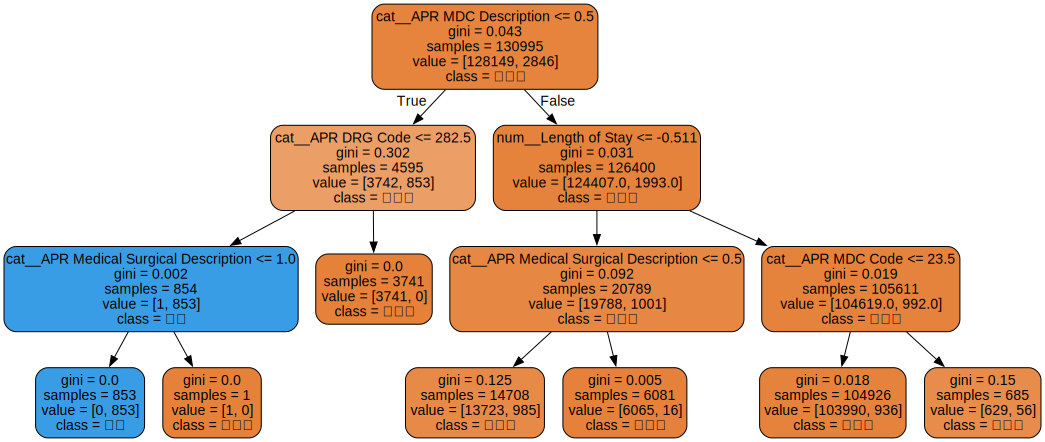

In [37]:
from sklearn.tree import export_graphviz
from graphviz import Source

# 시각화용 파이프라인에서 실제 모델 추출
tree_model = tree3.named_steps['model']  

# 전처리 후 특성 이름 추출
feature_names = preprocessor.get_feature_names_out()


src = export_graphviz(
    tree_model,
    feature_names=feature_names,
    class_names=['비이탈', '이탈'], 
    filled=True,
    rounded=True,
    max_depth=5
)


graph = Source(src)
graph.render("decision_tree", format="png", cleanup=False)  # 파일로 저장도 가능
graph


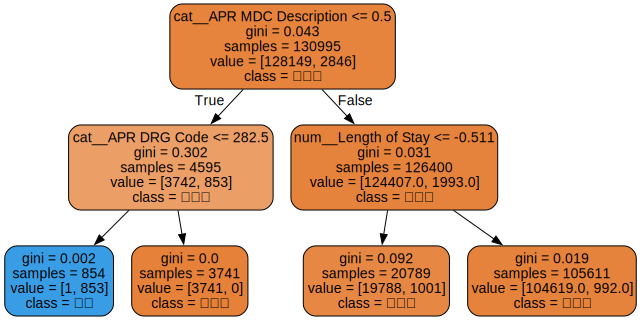

In [40]:
from sklearn.tree import export_graphviz
from graphviz import Source

# 1. 파이프라인에서 DecisionTreeClassifier만 추출
tree_model = tree2.named_steps['model']

# 2. 전처리 후의 실제 feature 이름 가져오기
feature_names = tree2.named_steps['preprocessor'].get_feature_names_out()

# 3. export_graphviz로 dot 코드 생성
src = export_graphviz(
    decision_tree=tree_model,
    feature_names=feature_names,
    class_names=['비이탈', '이탈'],  # 0: 비이탈, 1: 이탈
    filled=True,
    rounded=True,
    max_depth=3  # 시각화 범위 제한 (선택)
)

# 4. graphviz로 시각화
graph = Source(src)
graph

In [ ]:
최적의 하이퍼파라미터 찾기 

최적의 max_depth 찾기 

In [42]:
# max_depth 는 작을 수록 규제를 강하게 한다. 
## "규제를 강하게 한다." 의미: 모델의 복잡도를 낮추는 방향으로 학습시키는 것.

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 후보 max_depth 값
max_depth_list = range(1, 11)

# 결과 저장용 리스트
train_acc_list = []
test_acc_list = []

# 반복하면서 max_depth별 모델 학습 및 평가
for max_depth in max_depth_list:
    # 전처리 + 모델 파이프라인 구성
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Tree 기반이므로 preprocessor 사용
        ('model', DecisionTreeClassifier(max_depth=max_depth, random_state=0))
    ])
    
    # 학습
    pipeline.fit(X_train, y_train)
    
    # 예측
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    # 정확도 계산
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)

    # 저장
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"max_depth: {max_depth} | Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


max_depth: 1 | Train Acc: 0.9783, Test Acc: 0.9782
max_depth: 2 | Train Acc: 0.9848, Test Acc: 0.9844
max_depth: 3 | Train Acc: 0.9848, Test Acc: 0.9844
max_depth: 4 | Train Acc: 0.9848, Test Acc: 0.9844
max_depth: 5 | Train Acc: 0.9848, Test Acc: 0.9844
max_depth: 6 | Train Acc: 0.9848, Test Acc: 0.9844
max_depth: 7 | Train Acc: 0.9849, Test Acc: 0.9844
max_depth: 8 | Train Acc: 0.9850, Test Acc: 0.9844
max_depth: 9 | Train Acc: 0.9851, Test Acc: 0.9840
max_depth: 10 | Train Acc: 0.9854, Test Acc: 0.9847


In [43]:
train_acc_list

[0.9782739799228978,
 0.9847780449635483,
 0.984785678842704,
 0.984785678842704,
 0.9847933127218597,
 0.9848009466010154,
 0.9848772853925722,
 0.9849536241841291,
 0.9850834001297759,
 0.9854040230543151]

In [44]:
test_acc_list

[0.9782442748091603,
 0.9843511450381679,
 0.9843511450381679,
 0.9843511450381679,
 0.9843511450381679,
 0.9843511450381679,
 0.9843511450381679,
 0.9843511450381679,
 0.983969465648855,
 0.9847328244274809]

In [46]:
import pandas as pd

result_df = pd.DataFrame({
    "max depth": max_depth_list,
    "train acc": train_acc_list,
    "test acc": test_acc_list
})
result_df

,max depth,train acc,test acc
0,1,0.978274,0.978244
1,2,0.984778,0.984351
2,3,0.984786,0.984351
3,4,0.984786,0.984351
4,5,0.984793,0.984351
5,6,0.984801,0.984351
6,7,0.984877,0.984351
7,8,0.984954,0.984351
8,9,0.985083,0.983969
9,10,0.985404,0.984733


/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1916921570.py:10: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1916921570.py:10: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1916921570.py:10: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1916921570.py:10: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipykernel_39842/1916921570.py:10: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5n/23r0_lzd78l_tlx8j_f6613w0000gn/T/ipy

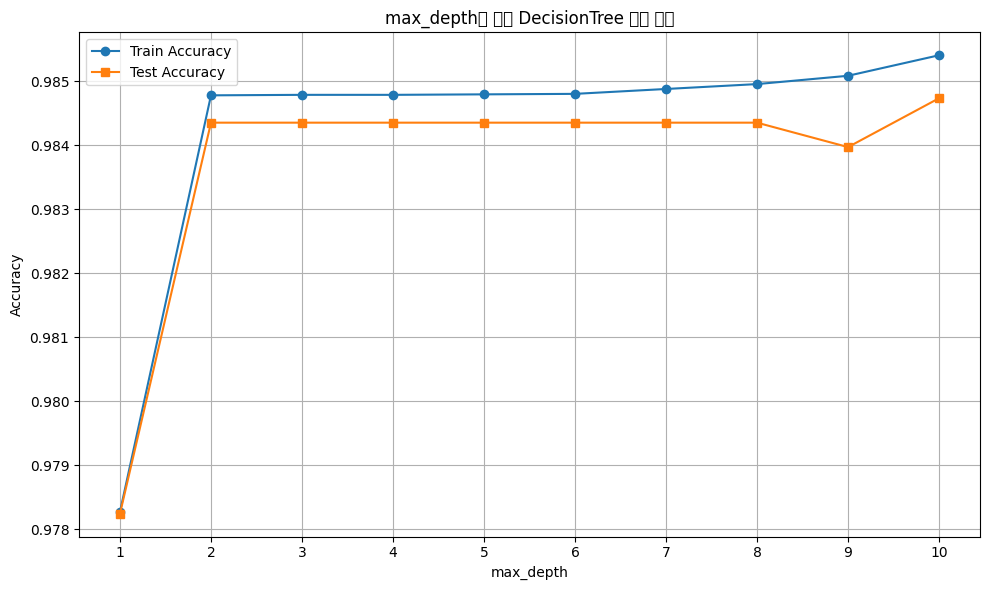

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, train_acc_list, marker='o', label='Train Accuracy')
plt.plot(max_depth_list, test_acc_list, marker='s', label='Test Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("max_depth에 따른 DecisionTree 성능 비교")
plt.xticks(max_depth_list)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
=========================================================================

In [ ]:
## RandomizedSearchCV



In [50]:
# 데이터 셋 분할 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. 파이프라인 정의 (전처리 + 모델)
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Tree 기반이므로 preprocessor 사용
    ('model', DecisionTreeClassifier(random_state=0))
])

# 2. 하이퍼파라미터 후보 정의
params = {
    'model__max_depth': range(1, 11),                      # 트리 깊이
    'model__max_leaf_nodes': range(10, 100, 5),            # 리프 노드 수
    'model__max_features': np.arange(0.1, 1.1, 0.1),       # 사용할 feature 비율
}

# 3. RandomizedSearchCV 정의
rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=params,
    n_iter=50,                   # 랜덤하게 50개 조합 테스트
    scoring='accuracy',         # 정확도 기준
    cv=4,                        # 4-fold 교차검증
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# 4. 탐색 시작
rs.fit(X_train, y_train)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


/Users/jangjinseul/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print("best parameter:", rs.best_params_)
print("best score:", rs.best_score_) 

In [ ]:
print("\n✅ 최적 하이퍼파라미터:")
print(rs.best_params_)

print(f"📈 Best Accuracy (CV 평균): {rs.best_score_:.4f}")

# 최적 모델 저장
best_dt_pipeline = rs.best_estimator_


In [ ]:
import pandas as pd
rs_result_df = pd.DataFrame(rs.cv_results_)
rs_result_df.sort_values('rank_test_score').head()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_dt = best_dt_pipeline.predict(X_test)

print("\n📊 Test Set 성능:")
print(classification_report(y_test, y_pred_dt, target_names=["비이탈", "이탈"]))

cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm, display_labels=["비이탈", "이탈"]).plot(cmap="Oranges")
plt.title("DecisionTree - 최적 모델 혼동행렬")
plt.show()


In [ ]:
rs_result_df.shape

In [ ]:
# best model 을 이용해 test set 최종평가 
best_model = rs.best_estimator_
accuracy_score(y_test, best_model.predict(X_test))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
✅ Best F1 Score : 0.461
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2563
           1       1.00      0.28      0.44        57

    accuracy                           0.98      2620
   macro avg       0.99      0.64      0.72      2620
weighted avg       0.98      0.98      0.98      2620



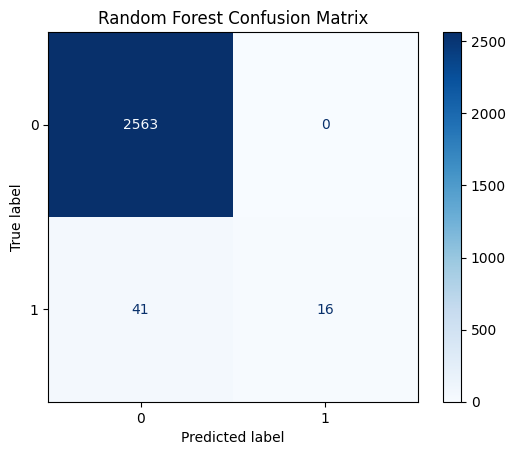

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

params_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10],
    'model__min_samples_split': [2, 5]
}

best_rf, rf_params, rf_score = get_best_model(
    RandomForestClassifier(random_state=0), params_rf, preprocessor, X_train, y_train)

y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def get_best_model(model, params, preprocessor, X_train, y_train):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grid=params, scoring='f1', cv=3, verbose=1)
    grid.fit(X_train, y_train)

    print("✅ Best Parameters:", grid.best_params_)
    print("✅ Best F1 Score :", round(grid.best_score_, 4))
    return grid.best_estimator_, grid.best_params_, grid.best_score_


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

def get_best_model(model, params, preprocessor, X_train, y_train):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    grid = RandomizedSearchCV(pipeline, param_grid=params, scoring='f1', cv=3, verbose=1)
    grid.fit(X_train, y_train)

    print("✅ Best Parameters:", grid.best_params_)
    print("✅ Best F1 Score :", round(grid.best_score_, 4))
    return grid.best_estimator_, grid.best_params_, grid.best_score_


In [ ]:
from sklearn.ensemble import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

params_rs = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10],
    'model__min_samples_split': [2, 5]
}

best_rs, rs_params, rs_score = get_best_model(
    RandomizedSearchCV(random_state=0), params_rf, preprocessor, X_train, y_train)

y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot(cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
# feature importances 찾아보기

# Pipeline에서 DecisionTreeClassifier 모델 꺼내기
tree_model = best_model.named_steps['model']

# 전처리 객체
preprocessor_fitted = best_model.named_steps['preprocessor']

# 카테고리형 feature (OrdinalEncoder 사용 → feature 이름 그대로 유지)
cat_features = preprocessor_fitted.transformers_[0][2]

# 수치형 feature
num_features = preprocessor_fitted.transformers_[1][2]

# 전체 feature 순서 정리
feature_names = list(cat_features) + list(num_features)

import pandas as pd

# 중요도 시리즈 생성 및 정렬
importances = pd.Series(tree_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

# 상위 20개 출력
print(importances.head(20))


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Decision Tree)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 데이터 셋 분할 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)